Dataset link: https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908

In [55]:
#@title Imports

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import math, datetime, re, operator
from datetime import date, timedelta

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics

In [56]:
#@title Unused code bank

# Here we need to process a bit our labels to be float, like 0 if nothing happened and 1 if there was smth bad...
# for i in range(0, len(labels)):
#   if isinstance(labels[i], str): labels[i] = 1
#   else: labels[i] = 0

# data["Date"] = pd.to_numeric(pd.to_datetime(data["Date"]))
# data["Time"] = data["Time"].replace('', '00:00')

# Somehow these methods do not work, gonna do individually
# data["Time"] = data["Time"].replace('c:', '')
# data["Time"] = data["Time"].replace('c: ', '')
# data["Time"] = data["Time"].replace('c', '')

# data["Date"] = pd.to_numeric(pd.to_datetime(data["Date"]))
# data["Date"] = pd.to_datetime(data["Date"])

# data["Location"] = data["Location"].replace('Near Sarowbi, Afghanistan', "Afghanistan")
# data["Time"] =  pd.to_timedelta(data["Time"])

# def rep(st):
#   var = st.replace('/', ' ')
#   var = var.split()
#   return var[-1]

# data['Date'] = data['Date'].apply(rep)

# features = pd.get_dummies(inf, columns = ["Location", "Operator", "Route", "Type"])

# from sklearn.preprocessing import OneHotEncoder

# inf["Route"] = inf["Route"].replace("Not known", 0)
# inf["Location"] = OneHotEncoder().fit_transform(inf[["Location"]])

# le = preprocessing.LabelEncoder()
# columns = ["Location", "Operator", "Route", "Type"]
# inf[columns] = inf[columns].apply(le.fit_transform)
# inf["Aboard"] = le.fit_transform(inf["Aboard"])

In [57]:
#@title Data preprocessing

data = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")

data["Time"] = data["Time"].replace('c16:50', '16:50')
data["Time"] = data["Time"].replace('12\'20', '12:20')
data["Time"] = data["Time"].replace('18.40', '18:40')
data["Time"] = data["Time"].replace('114:20', '14:20')
data["Time"] = data["Time"].replace('c14:30', '14:30')
data["Time"] = data["Time"].replace('0943', '09:43')
data["Time"] = data["Time"].replace('22\'08', '22:08')
data["Time"] = data["Time"].replace('17.0', '17:00')
data["Time"] = data["Time"].replace(np.nan, '00:00')

data["Time"] = data["Time"].replace('c: 1:00', '1:00')
data["Time"] = data["Time"].replace('c:17:00', '17:00')
data["Time"] = data["Time"].replace('c: 2:00', '2:00')
data["Time"] = data["Time"].replace('c:09:00', '09:00')
data["Time"] = data["Time"].replace('c: 9:40', '9:40')

data["Date"] = data["Date"].replace('o', '')
data['Time'] = data['Date'] + ' ' + data['Time']

def conversion(str_date):
  dtc = datetime.datetime.strptime(str_date, '%m/%d/%Y %H:%M')
  return dtc

def pr_f(locat):
  try:
    m = locat.split(",")[-1].lstrip()
  except:
    m = locat
  return m

def pr_d(locat):
  try:
    m = locat.split("/")[-1].lstrip()
  except:
    m = locat
  return m

data['Time'] = data['Time'].apply(conversion)

# data['Location'] = data['Location'].apply(pr_f)

# for i in data['Location']:
#   try:
#     data['Location'][i] = pr_f(data['Location'][i])
#   except: pass

data['Location'] = data['Location'].apply(pr_f)
data['Date'] = data['Date'].apply(pr_d)

data = data.replace(np.nan, "Not known")
data["Fatalities"] = data["Fatalities"].replace('Not known', 0)

del data['Flight #']
del data['cn/In']
del data['Ground']
del data['Registration']

data.head(10)

# data.isnull().sum()

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Summary
0,1908,1908-09-17 17:18:00,Virginia,Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,"During a demonstration flight, a U.S. Army fly..."
1,1912,1912-07-12 06:30:00,New Jersey,Military - U.S. Navy,Test flight,Dirigible,5.0,5.0,First U.S. dirigible Akron exploded just offsh...
2,1913,1913-08-06 00:00:00,Canada,Private,Not known,Curtiss seaplane,1.0,1.0,The first fatal airplane accident in Canada oc...
3,1913,1913-09-09 18:30:00,Over the North Sea,Military - German Navy,Not known,Zeppelin L-1 (airship),20.0,14.0,The airship flew into a thunderstorm and encou...
4,1913,1913-10-17 10:30:00,Germany,Military - German Navy,Not known,Zeppelin L-2 (airship),30.0,30.0,Hydrogen gas which was being vented was sucked...
5,1915,1915-03-05 01:00:00,Belgium,Military - German Navy,Not known,Zeppelin L-8 (airship),41.0,21.0,Crashed into trees while attempting to land af...
6,1915,1915-09-03 15:20:00,Germany,Military - German Navy,Not known,Zeppelin L-10 (airship),19.0,19.0,"Exploded and burned near Neuwerk Island, when..."
7,1916,1916-07-28 00:00:00,Bulgeria,Military - German Army,Not known,Schutte-Lanz S-L-10 (airship),20.0,20.0,"Crashed near the Black Sea, cause unknown."
8,1916,1916-09-24 01:00:00,England,Military - German Navy,Not known,Zeppelin L-32 (airship),22.0,22.0,Shot down by British aircraft crashing in flames.
9,1916,1916-10-01 23:45:00,England,Military - German Navy,Not known,Zeppelin L-31 (airship),19.0,19.0,Shot down in flames by the British 39th Home D...


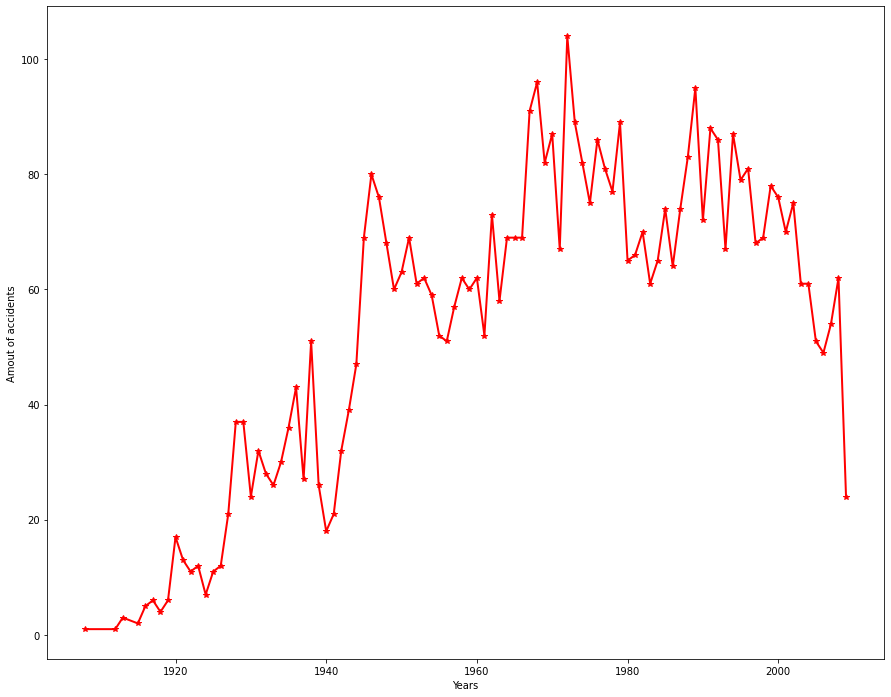

In [58]:
#@title Accidents through years

inf = data.groupby(data.Time.dt.year)[['Date']].count()

plt.figure(figsize=(15,12))
plt.plot(inf.index, 'Date', data=inf, color='red', marker = "*", linewidth=2)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amout of accidents', fontsize=10)

# font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 2}
# plt.rc('font', **font)

plt.show()

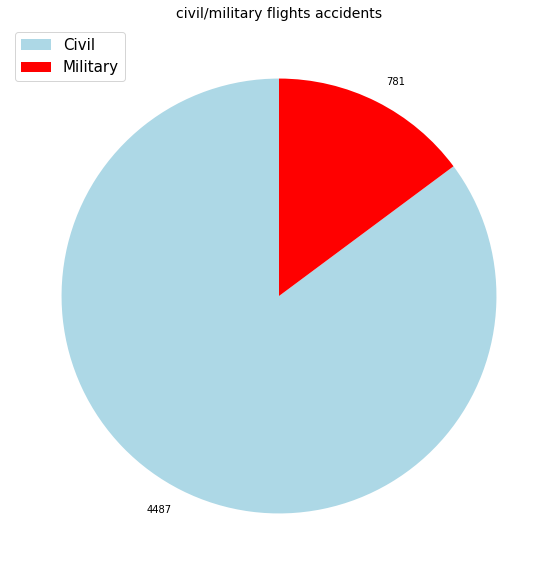

In [59]:
#@title Civil to military comparison

plt_d = data.copy()
plt_dd = data.copy()

plt_d['isMilitary'] = plt_d.Operator.str.contains('Military')
plt_d = plt_d.groupby('isMilitary')[['isMilitary']].count()
plt_d.index = ['Civil', 'Military']


plt_dd['Military'] = plt_dd.Operator.str.contains('Military')
plt_dd['Civil'] = plt_dd.Military == False

plt_dd = plt_dd.loc[:, ['Time', 'Military', 'Civil']]
plt_dd = plt_dd.groupby(plt_dd.Time.dt.year)[['Military', 'Civil']].aggregate(np.count_nonzero)

plt.figure(figsize=(15, 10))


plc, pls = plt.pie(plt_d.isMilitary, labels=plt_d.isMilitary, colors=['lightblue', 'red'], startangle=90)
# plt.pie(expenses, labels=labels, autopct=lambda pct: func(pct), explode=[0,0,0,0,0.2,0], shadow=True)
plt.legend(plc, plt_d.index, loc="best", fontsize=15)
plt.title('civil/military flights accidents', fontsize=14)
plt.show()


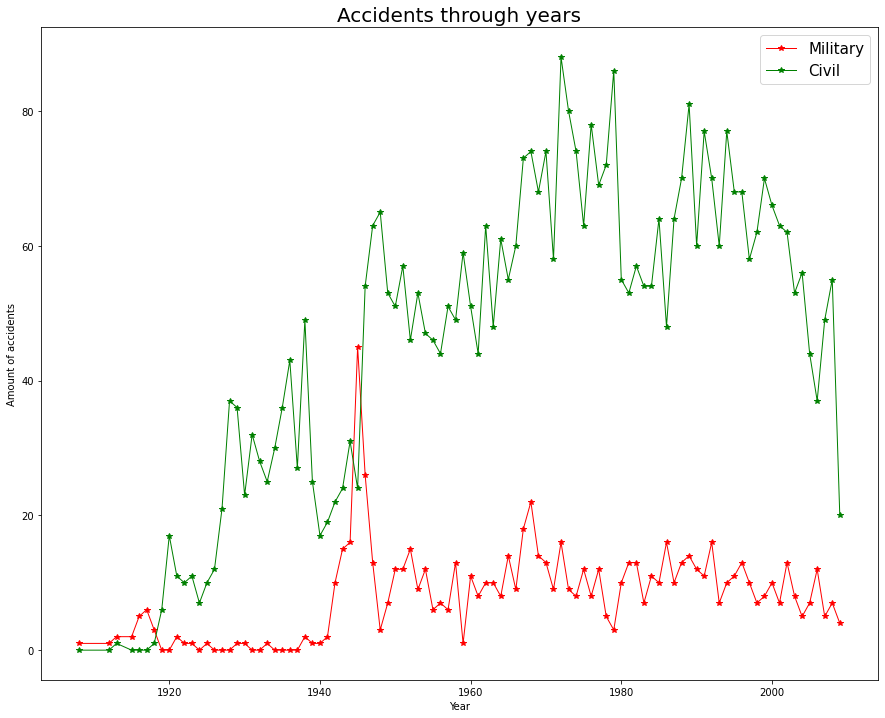

In [60]:
#@title Accidents through years
plt.figure(figsize=(15, 12))

plt.plot(plt_dd.index, 'Military', data=plt_dd, color='red', marker = "*", linewidth=1)
plt.plot(plt_dd.index, 'Civil', data=plt_dd, color='green', marker = "*", linewidth=1)

plt.legend(fontsize=15)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Amount of accidents', fontsize=10)
plt.title('Accidents through years', fontsize=20)
plt.show()

# Defining RandomForestClassifier model and training it for futher anaysing

In [61]:
inf = (data[["Date", "Location", "Operator",  "Route", "Type", "Aboard"]]).copy()

features = pd.get_dummies(inf)#, columns = ["Location", "Operator", "Route", "Type"])

labels = data["Fatalities"].astype('int')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=math.ceil(len(data)*0.2), random_state=5)

model = RandomForestClassifier(n_estimators=500, max_depth=75, min_samples_split=20, min_samples_leaf=1, criterion='entropy', bootstrap=False)
model.fit(X_train, y_train)

acc = accuracy_score(y_test, model.predict(X_test)) * 100
print(round(acc, 2))

62.81


In [62]:
inf.head(5)

,Date,Location,Operator,Route,Type,Aboard
0,1908,Virginia,Military - U.S. Army,Demonstration,Wright Flyer III,2.0
1,1912,New Jersey,Military - U.S. Navy,Test flight,Dirigible,5.0
2,1913,Canada,Private,Not known,Curtiss seaplane,1.0
3,1913,Over the North Sea,Military - German Navy,Not known,Zeppelin L-1 (airship),20.0
4,1913,Germany,Military - German Navy,Not known,Zeppelin L-2 (airship),30.0


In [63]:
#@title Analysing which parameters imply the accuracy the most

# plt.figure(figsize=(15,15)) 
# plt.barh(X_train.columns, model.feature_importances_)

In [64]:
#@title Looking for best parameters

# from sklearn.model_selection import RandomizedSearchCV


# n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# max_features = ['auto', 'sqrt']
# max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# min_samples_leaf = [1, 2, 3, 4]
# bootstrap = [True, False]
# criterion=['gini', 'entropy']

# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
#                'criterion': criterion}

# rf_base = RandomForestClassifier()

# rf_random = RandomizedSearchCV(estimator = rf_base,
#                                param_distributions = random_grid,
#                                n_iter = 30, cv = 5,
#                                verbose=2,
#                                random_state=42, n_jobs = 4)
# rf_random.fit(X_train, y_train)

# print (rf_random.score(X_train, y_train))
# print(rf_random.score(X_test, y_test))

In [65]:
#@title References

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908
# https://www.kaggle.com/code/ruslankl/airplane-crashes-data-visualization
